In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


# Clone github repo

In [1]:
# Clone the entire repo.
!git clone https://github.com/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-.git
%cd Vietnamese-Reactionary-Article-Classification-/
!ls

Cloning into 'Vietnamese-Reactionary-Article-Classification-'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 58 (delta 9), reused 48 (delta 6), pack-reused 0
Unpacking objects: 100% (58/58), done.
/content/Vietnamese-Reactionary-Article-Classification-
analysis  data	demo  modeling	README.md


# Import Libs

In [2]:
!pip install vinorm

import re
import seaborn as sns
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pickle
from vinorm import TTSnorm

tqdm.pandas()

plt.rcParams["figure.figsize"] = (15,5)

     |████████████████████████████████| 40.4MB 109kB/s 


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Import data from GDRIVE

In [3]:
%cd data/datasets/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data/datasets
0  1  README.md


In [4]:
dataset_1 = os.listdir(os.getcwd() + '/1/')
dataset_0 = os.listdir(os.getcwd() + '/0/')

print(dataset_1)
print(dataset_0)


['viettan_org_4.csv', 'KhoaLuatTapChi_XaHoi.csv', 'sbtn.csv', 'thanhnienconggiao.csv', 'KhoaLuatTapChi_VNCH.csv', 'haudue_vnch.csv', 'khoi8406.csv', 'viettan_org_3.csv', 'PhamMinhVuFBd.csv', 'GiaoChucChuVanAn.csv', 'chantroimoi_media.csv', 'viettan_org.csv', 'viettan_fb.csv', 'KhoaLuatTapChi_ChinhTri.csv', 'bpsos.csv', 'rfa.csv', 'viettan_org_2.csv']
['vnexpress-chinhtri_2.csv', 'vnexpress-chinhtri.csv', 'tinnoichinh.csv']


# Preprocessing

- Clean html
- Normalize unicode
- Drop missing values
- Remove short posts
- Remove hyperlinks
- Replace abbreviation
- Check chính tả
- Keep number, special character, punctuation since BERT can handle all of them

In [121]:
class Dataframe:
    
    def __init__(self):
        self.directory = ''
        self.name = ''

        self.df = []
        self.df_word_segment = []
        self.vocab = []

        self.word_segment = []
        self.stop_words = {}

        self.label = 0


    def __init__(self, directory, label):
        self.name = directory
        self.directory = directory
        self.label = label

    # read csv file and add label column
    def read_csv(self):
        df = pd.read_csv(os.getcwd() + self.directory)
        df = df.drop(['Unnamed: 0'], axis = 1)
        if 'blue' in df.columns:
            df.rename(columns = {'blue': 'content'}, inplace = True)
        df['label'] = np.ones((df.shape)).astype('int')
        df['label'].astype('category')
        df['avg_length'] = df['content'].apply(len)



        self.df = df

    def drop_missing(self): 
        self.df = self.df.dropna()

    def plot(self): #df
        plt.style.use('ggplot')
        plt.figure(figsize = (15, 10))
        sns.rugplot(self.df['avg_length'])

        sns.rugplot(self.df['avg_length'])
        plt.show()

        sns.displot(self.df['avg_length'])
        plt.show()

        sns.kdeplot(self.df['avg_length'])
        plt.show()

        sns.ecdfplot(self.df['avg_length'])
        plt.show()

    def preprocess(self):
        def clean_html(raw_html): #text
            cleanr = re.compile('<.*?>')
            cleantext = re.sub(cleanr, '', raw_html)
            return cleantext

         # Normalize unicode
        def normalize_unicode(txt): # text
            def loaddicchar():
                dic = {}
                char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
                    '|')
                charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
                    '|')
                for i in range(len(char1252)):
                    dic[char1252[i]] = charutf8[i]
                return dic

            def convert_unicode(txt):
                dicchar = loaddicchar()
                return re.sub(
                    r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
                    lambda x: dicchar[x.group()], txt)
            return convert_unicode(txt)
                
         # Remove short articles
        def remove_short(limit): #df
            self.df = self.df[self.df['avg_length'] > limit]

        # Remove long articles
        def remove_long(limit): #df
            self.df = self.df[self.df['avg_length'] < limit]

        # Remove hyperlinks in text
        def remove_urls(input_text): #text
            return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

        # Normalize Vietnamese
        def normalize_vietnamese():
            self.df['content'] = self.df['content'].progress_apply(lambda x: TTSnorm(x, lower = False, punc = True))



        self.df['content'] = self.df['content'].apply(clean_html)
        self.df['content'] = self.df['content'].apply(normalize_unicode)
        self.df['content'] = self.df['content'].apply(remove_urls)

        limit = input('Enter < limit:')
        limit = int(limit)

        remove_short(limit)

        limit = input('Enter > limit:')
        limit = int(limit)

        remove_long(limit)
        normalize_vietnamese()

        

    # Save dataframe to pickle file
    def save_preprocess(self, name):
        file_name = name + '.pickle'
        pickling_on = open(file_name,"wb")
        pickle.dump(self.df, pickling_on)
        pickling_on.close()
 


# word Tokenize and remove stopwords 
def word_tokenize_w_remove_stopwords():
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    from nltk.tokenize import word_tokenize

    text = "Nick likes to play football, however he is not too fond of tennis."
    text_tokens = word_tokenize(text)

    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

    print(tokens_without_sw)

# Perform on datasets

## Viettan

### Define new instances

In [143]:
test = Dataframe('/1/' + dataset_1[1], 1)
test.read_csv()
test.drop_missing()

print(test.name)
df = test.df

/1/KhoaLuatTapChi_XaHoi.csv


### Content Filter

### Plot distribution

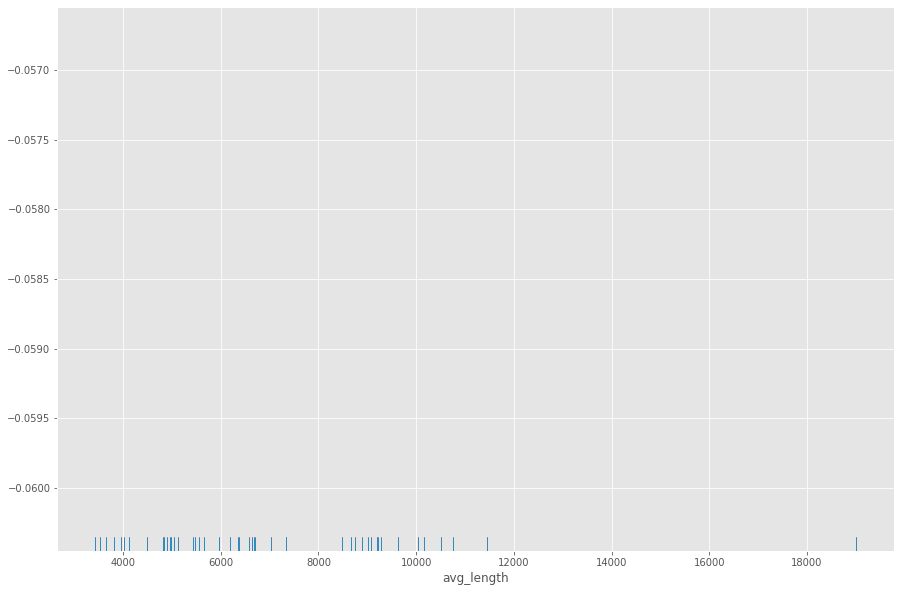

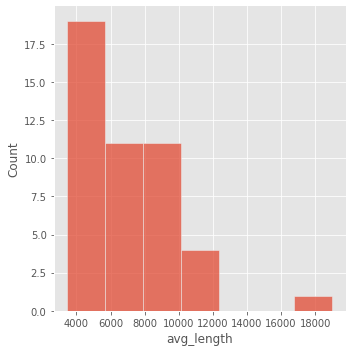

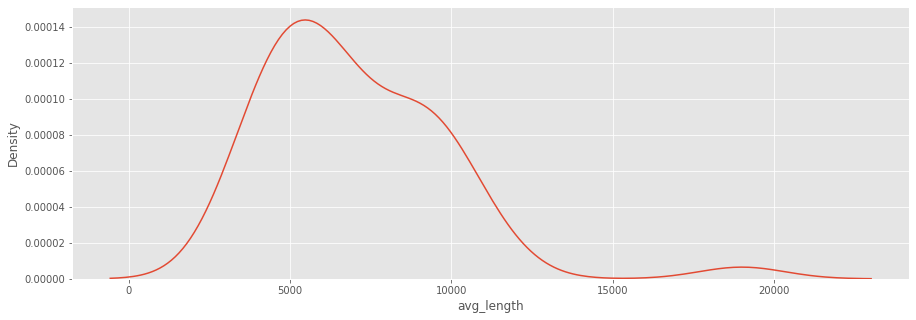

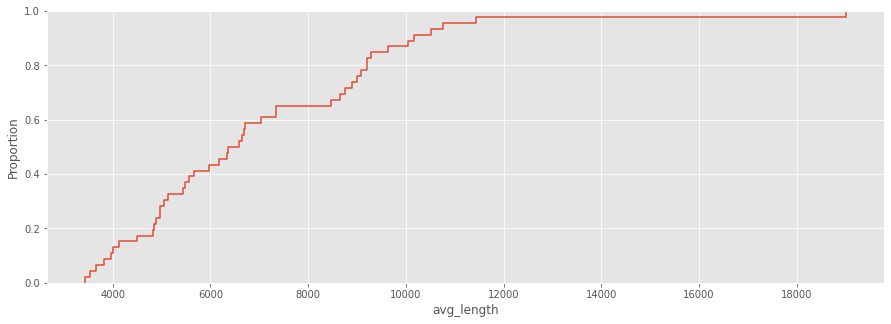

In [123]:
test.plot()

### Observations

In [133]:
limit = 4000

In [134]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

4     2020 thật gian nan, nhưng cuộc sống vẫn tiếp d...
27    Đại dịch: Cơ hội để con người thay đổi lối sốn...
31    Dự báo hậu COVID-19: Tự do thông tin và khoa h...
35    Dự báo hậu COVID-19: Giáo dục trực tuyến sẽ đó...
37    Dự báo hậu COVID-19: Dịch vụ y tế từ xa sẽ ngà...
Name: content, dtype: object
--------------------



2020 thật gian nan, nhưng cuộc sống vẫn tiếp diễn
2020 thật gian nan, nhưng cuộc sống vẫn tiếp diễn
12 tháng trước, không ai có thể mường tượng được rằng 2020 lại khó sống đến vậy.. 
Cơn đại dịch ập đến và ở lại không hẹn ngày đi, khiến cuộc sống của mọi người trên khắp thế giới trở nên bất định. Ở Việt Nam, kể từ khi dịch COVID-19 bùng phát, người dân như đi trên một chiếc tàu lượn siêu tốc: tình hình cứ tốt lên rồi lại xấu đi, người ta cứ hy vọng rồi lại thất vọng, vừa vui được chốc lát đã lại chìm vào giận dữ. Chung quanh bàn ăn mỗi sáng, nhà nhà đều bàn luận về cuộc chiến chống lại COVID-19, sức khỏe của nền kinh tế, và những nỗ lực nhằm giảm thiểu tác độ

In [115]:
limit = 30000

In [109]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[2])

165    Tự Do Chính Trị: Nền Tảng Cho Trí Thức Và Nhân...
196    220 Sự Kiện Nổi Bật Của Phong Trào Tranh Đấu D...
Name: content, dtype: object
--------------------





IndexError: ignored

### Run Preprocessing method

In [116]:
# 600 - 30000
# ...
test.preprocess()

Enter < limit:600
Enter > limit:30000


KeyboardInterrupt: ignored